# Talktorial 05

# Affinity prediction with convolutional neural networks

#### CADD Seminar 2020, AG Volkamer, Charité/FU Berlin 

#### Hazem Ahmed

Berlin, May 2020

# Aim
The aim of this project is to build a CNN (Convolutional Neural Network) which can predict the inhibitory activity of some compounds on Epithelial growth factor receptor (EGFR) based on the half-maximal inhibitory concentration (IC50).


## Theory


* ChEMBL database
* Compound activity measures
* CNNs (convolutional neural network). (SMILES ??)

## Practical

* Load part of ChEMBL database
* Derive the one-hot encoding of the SMILES representing the molecules.
* Design the CNNs
* Convert the one-hot encoded molecules to a suitable 4d tensor and pIC50 to 1d tensor. 
* Train our regression model.
* Calculate pIC50 based on our model.
* Compare the results with linear network of project T04.


# References

https://www.eurekaselect.com/98659/article #IC50

http://datascience.unm.edu/biomed505/Course/Cheminformatics/basic/descs_fingers/molec_descs_fingerprints.htm #molecule_descriptors

https://pubs.acs.org/doi/abs/10.1021/jm401411z #molecule_descriptors

https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/ #Onehot encoding tips

https://iwatobipen.wordpress.com/2017/01/22/encode-and-decode-smiles-strings/ #one hot encoding tips

https://towardsdatascience.com/find-and-play-with-molecule-datasets-ef1116e4524f #databases description

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5 #a good CNN paper

https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd #Tensors dimensions
https://pythonprogramming.net/convnet-model-deep-learning-neural-network-pytorch/ 
https://github.com/pytorch/examples/blob/master/mnist/main.py

# Theory

## ChEMBL database

The ChEMBL is a dataset developed by the European Bioinformatics Institute providing information regarding the SMILES (Simplified Molecular Input Line Entry System), chemical properties activity and genomics of over 1.9 billion compounds.
Among these molecules, there are the molecules with drug like properties. The dataset used for CNN training here is a subset of the huge ChEMBL database.

## SMILES

* A SMILE is a representaton of the 2D structure of molecules using characters.
* This string of characters could be easily coded using one-hot encoding meaning that this representation will also contain information about the structure of the molecule


## Compound activity measures

Molecules bind to receptors or enzymes through pockets in which they fit into it. After binding they induce or inhibit the activity of the enzyme modulating several biological activities (signal transduction, cell growth etc...). 

Half maximal inhibitory concentration (IC50) is one of the measures that can assess the inhibitory activity of molecules. 
It is the concentration of a molecule at which the molecule exerts half the maximum inhibitory effect that can be achieved for this biological function. 

## Convolutional Neural Networks (CNNs)

Convolution in general is an operation on two functions that expresses the way one of them is changing based on the other. 
In convolutional neural network the first function is the input and the second is usually a kernel.
The idea of the network is depicted in the following figure (Adopted from : https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53). 

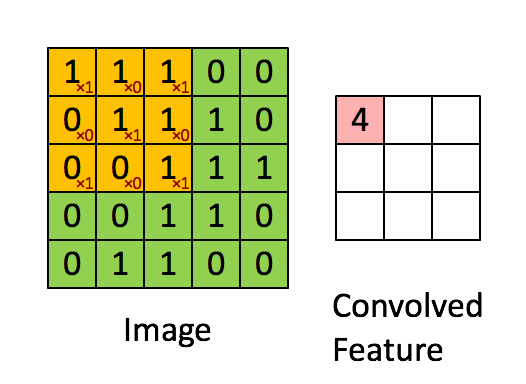

In that figure:
- The input image is a matrix of 5*5 while the kernel is 3*3.
- The Kernel moves with specific stride (1 in the example above) calculates the pixels over this part.
- The resulting matrix is then pooled (depending on the poooling method used) and the most significant pixel is taken. 
The whole process is shown in the following figure (Adopted from : https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53). 

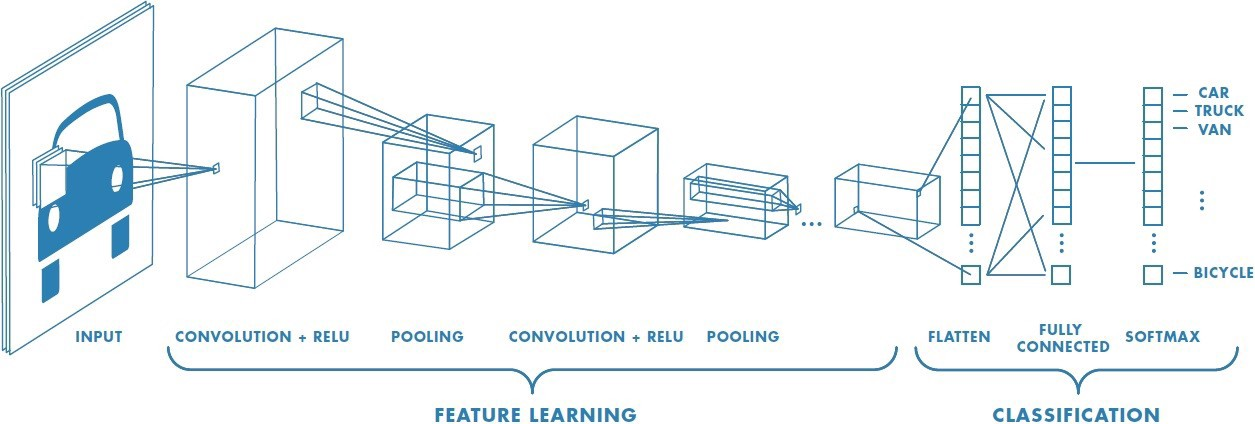

# Practical

## The imports we do for our code

List of packages installed: 
* !conda install pytorch --yes
* !pip install pandas
* !pip install numpy
* !pip install sklearn
* !pip install matplotlib
* !conda env list
* conda list

In [106]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
from skorch import NeuralNetRegressor
from sklearn.model_selection import cross_val_predict
# Graphics modules
import seaborn as sns
import visdom
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to ChEMBL database

The First step is to load the dataset that is a subset of ChEMBL database from the github repository.

In [2]:
# Here both options are given, whether to get the data from a local directory or URL
data_dir = "/volumes/data/Bioinformatics_master/Second_semester/CADD/CADDSeminar_2020/"
data_URL = ('https://raw.githubusercontent.com/volkamerlab/CADDSeminar_2020/master/data'
            '/CHEMBL25_activities_EGFR.csv?token=AFRFK52VHK5JFMBGTJIPDZC67XNPK')

In [3]:
# if local directory type f'{data_dir}'/file_name.csv
df_data = pd.read_csv(data_URL)

In [4]:
df_data.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,6373,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,2442,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,1084,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


## Create One-hot encoding vector
Next step is to convert the SMILEs to the one-hot encoded vector

In [5]:
df_smiles = df_data["canonical_smiles"]
print(df_data["canonical_smiles"].map(lambda x: len(x)).max())
# to get the highest string length of my smiles

267


In [6]:
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']
smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))
index2smi = dict((i, c) for i, c in enumerate(SMILES_CHARS))
# the following function is obtained in the light of the following link
# https://iwatobipen.wordpress.com/2017/01/22/encode-and-decode-smiles-strings/


def smiles_encoder(smiles, maxlen):
    """Takes Smiles charcater sequence as a string concerting it to one-hot ecoded vector.


    Parameters:

    Smiles (Cahracter str): A set of charcter strings describing the molecule
    Maxlen (int.): the maximum character length for this set of strings

    Returns:

    float64: a matrix of floats zeros and ones of size maxlen


    """
    # smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    X = np.zeros((maxlen, len(SMILES_CHARS)))
    for i, c in enumerate(smiles):
        X[i, smi2index[c]] = 1
    return X


def smiles_decoder(X):
    """Takes a matrix of one hot encoded data and returns a smile


    Parameters:

    X as a matrix of one hot encoded vector.

    Returns:

    str1: a character string representing the molecule smile


    """
    smi = ''
    X = X.argmax(axis=-1)
    for i in X:
        smi += index2smi[i]
    return smi

In [7]:
df_smiles[2]

'FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](C)CC5)cc4)ncc3n2)ccc1'

In [8]:
smiles_length = [len(df_smiles[i]) for i in range(3906)]

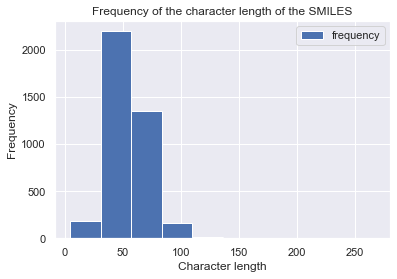

In [52]:
# plottiing the lengths of thr smiles
plt.hist(smiles_length, label="frequency", bins=10)
plt.title("Frequency of the character length of the SMILES")
plt.xlabel("Character length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
# to remove the very long or very short smiles
df_no_long_smiles = pd.DataFrame([])
for i in range(3906):
    if (len(df_data.iloc[i, 4]) < 110):
        df_no_long_smiles = df_no_long_smiles.append(df_data.iloc[i])

In [11]:
df_no_long_smiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 0 to 3905
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IC50              3893 non-null   float64
 1   Unnamed: 0        3893 non-null   float64
 2   canonical_smiles  3893 non-null   object 
 3   chembl_id         3893 non-null   object 
 4   pIC50             3893 non-null   float64
 5   units             3893 non-null   object 
dtypes: float64(3), object(3)
memory usage: 212.9+ KB


In [12]:
# Maximum length in the new dataframe
print(df_no_long_smiles["canonical_smiles"].map(lambda x: len(x)).max())

109


In [13]:
df_smiles_short = df_no_long_smiles["canonical_smiles"]

In [14]:
G = smiles_encoder(df_smiles_short[2], 109)
print(G)  # as an example that the function works
len(G)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


109

In [15]:
occurrences_1 = np.count_nonzero(G == 1)
occurrences_0 = np.count_nonzero(G == 0)
print(occurrences_1)
print(occurrences_0)

67
6037


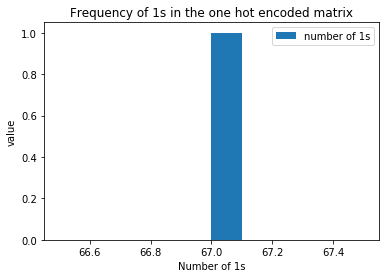

In [16]:
plt.hist(occurrences_1, label="number of 1s")
plt.title("Frequency of 1s in the one hot encoded matrix")
plt.xlabel("Number of 1s")
plt.ylabel("value")
plt.legend()
plt.show()

In [17]:
smiles_decoder(G)  # example that my decoder works

'FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](C)CC5)cc4)ncc3n2)ccc1                                          '

In [18]:
one_hot_encode_smiles_short = [smiles_encoder(df_smiles_short.iloc[i],
                                              109) for i in range(3893)]
one_hot_encode_smiles_short[5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## CNN
### create the tensor inputs and outputs
Here we create the tensors with the correct dimensions for the CNN

In [19]:
# Create a tensor from our list
smiles_t = torch.Tensor(one_hot_encode_smiles_short)
smiles_t[1]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
print("Array Type: {}".format(smiles_t.type))
print("Array Type: {}".format(smiles_t.shape))
print(smiles_t)

Array Type: <built-in method type of Tensor object at 0x7faa8de7d9c0>
Array Type: torch.Size([3893, 109, 56])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
        

In [21]:
# The prediction values
pIC50 = df_no_long_smiles["pIC50"]
pIC50 = pIC50.to_numpy()
pIC50_input = torch.Tensor(pIC50)  # output tensor
pIC50_input

tensor([7.1135, 6.4815, 9.0000,  ..., 8.0458, 7.4868, 8.3979])

In [22]:
# Here I convert the input data to a 4d tensor suitable for conv2d()
smiles_t_CNN_input = smiles_t.resize_([3751, 1, 109, 56])
smiles_t_CNN_input
pIC50_CNN_train = pIC50_input.resize_([3751, 1])
pIC50_CNN_train

tensor([[7.1135],
        [6.4815],
        [9.0000],
        ...,
        [4.2700],
        [5.8962],
        [8.2076]])

In [23]:
print("Array Type: {}".format(smiles_t_CNN_input.type))
print("Array Type: {}".format(smiles_t_CNN_input.shape))
print(smiles_t_CNN_input)  # view my tensors

Array Type: <built-in method type of Tensor object at 0x7faa8de7d9c0>
Array Type: torch.Size([3751, 1, 109, 56])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0.

In [24]:
print("Array Type: {}".format(pIC50_CNN_train.type))
print("Array Type: {}".format(pIC50_CNN_train.shape))
print(pIC50_CNN_train)

Array Type: <built-in method type of Tensor object at 0x7faa8de8b4c0>
Array Type: torch.Size([3751, 1])
tensor([[7.1135],
        [6.4815],
        [9.0000],
        ...,
        [4.2700],
        [5.8962],
        [8.2076]])


### Design the CNN

Here I design the CNN itself:-
* Two convolutional layers.
* Three fully connected linear layers.

In [ ]:
###### Design for CNN
# Inspired by:
# https://pythonprogramming.net/convnet-model-deep-learning-neural-network-pytorch/
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 11)  # (input, features, kernel)
        self.conv2 = nn.Conv2d(3, 6, 11)
        # self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(109, 56).view(-1, 1, 109, 56)
        self._to_linear = None
        # generate a dummy array where our
        # /values to be flattened will be introduced inside
        self.convs(x)
        # Pooling and flattening to prepare for the linear network
        # Linear function
        self.fc1 = nn.Linear(self._to_linear, 256)  # flattening
        # self.fc1 = nn.Linear(64*32*32, 128)  # flattening
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def convs(self, x):
        # Max pooling over 3x3
        x = F.max_pool2d(F.relu(self.conv1(x)), (3, 3))
        x = F.max_pool2d(F.relu(self.conv2(x)), (3, 3))
        # x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        # .view is reshape ... this flattens X before
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        # bc this is our output layer. No activation here.
        return x


net = Net()
print(net)

In [ ]:
# I usually use the other design but this is also nother
# inspired by https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(49920, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, 1)
        # x = torch.randn(267, 56).view(-1, 1, 267, 56)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        # print(x[0].shape)
        # print(x.size())
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


net = Net()
net

In [26]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

12
torch.Size([3, 1, 11, 11])


In [28]:
# Optimizer and Loss Function
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss()

### Model training

In [29]:
vis = visdom.Visdom()  # visualize the loss
# create the map where the loss would be drawn
loss_window = vis.line(
   Y=torch.zeros((1)).cpu(),
   X=torch.zeros((1)).cpu(),
   opts=dict(xlabel='epoch', ylabel='Loss', title='training loss', legend=['Loss']))
if torch.cuda.is_available():  # gpu adapted
    net.cuda()

Setting up a new session...


In [30]:
epochs = 200  # Epoches
for epoch in tqdm(range(epochs)):  # Converting inputs and labels to Variable (first 50)
    if torch.cuda.is_available():
        inputs = Variable(smiles_t_CNN_input.cuda())
        labels = Variable(pIC50_CNN_train.cuda())
    else:
        inputs = Variable(smiles_t_CNN_input)
        labels = Variable(pIC50_CNN_train)
    # Clear gradient buffers
    optimizer.zero_grad()
    # get output from the model, given the inputs
    outputs = net(inputs)
    # get loss for the predicted output
    loss = loss_function(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()
    # update parameters
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    vis.line(X=torch.ones((1, 1)).cpu()*epoch,
             Y=torch.Tensor([loss]).unsqueeze(0).cpu(),
             win=loss_window, update='append')

  0%|          | 0/200 [00:00<?, ?it/s]

tensor(47.2872, grad_fn=<MseLossBackward>)


  0%|          | 1/200 [00:17<57:25, 17.32s/it]

epoch 0, loss 47.287193298339844
tensor(47.2644, grad_fn=<MseLossBackward>)


  1%|          | 2/200 [00:35<57:57, 17.56s/it]

epoch 1, loss 47.26439666748047
tensor(47.2417, grad_fn=<MseLossBackward>)


  2%|▏         | 3/200 [00:45<50:31, 15.39s/it]

epoch 2, loss 47.241722106933594
tensor(47.2191, grad_fn=<MseLossBackward>)


  2%|▏         | 4/200 [01:15<1:04:41, 19.80s/it]

epoch 3, loss 47.2191047668457
tensor(47.1965, grad_fn=<MseLossBackward>)


  2%|▎         | 5/200 [01:31<1:00:23, 18.58s/it]

epoch 4, loss 47.19645690917969
tensor(47.1738, grad_fn=<MseLossBackward>)


  3%|▎         | 6/200 [02:04<1:14:25, 23.02s/it]

epoch 5, loss 47.17375946044922
tensor(47.1510, grad_fn=<MseLossBackward>)


  4%|▎         | 7/200 [02:15<1:02:27, 19.42s/it]

epoch 6, loss 47.151039123535156
tensor(47.1283, grad_fn=<MseLossBackward>)


  4%|▍         | 8/200 [02:25<52:46, 16.49s/it]  

epoch 7, loss 47.128273010253906
tensor(47.1055, grad_fn=<MseLossBackward>)


  4%|▍         | 9/200 [02:34<45:25, 14.27s/it]

epoch 8, loss 47.10549545288086
tensor(47.0827, grad_fn=<MseLossBackward>)


  5%|▌         | 10/200 [02:44<40:41, 12.85s/it]

epoch 9, loss 47.082740783691406
tensor(47.0600, grad_fn=<MseLossBackward>)


  6%|▌         | 11/200 [02:54<37:39, 11.95s/it]

epoch 10, loss 47.060028076171875
tensor(47.0374, grad_fn=<MseLossBackward>)


  6%|▌         | 12/200 [03:03<35:03, 11.19s/it]

epoch 11, loss 47.03742599487305
tensor(47.0150, grad_fn=<MseLossBackward>)


  6%|▋         | 13/200 [03:13<33:17, 10.68s/it]

epoch 12, loss 47.01498794555664
tensor(46.9927, grad_fn=<MseLossBackward>)


  7%|▋         | 14/200 [03:24<33:30, 10.81s/it]

epoch 13, loss 46.992713928222656
tensor(46.9706, grad_fn=<MseLossBackward>)


  8%|▊         | 15/200 [03:35<33:24, 10.83s/it]

epoch 14, loss 46.97062683105469
tensor(46.9487, grad_fn=<MseLossBackward>)


  8%|▊         | 16/200 [03:44<32:12, 10.50s/it]

epoch 15, loss 46.94865798950195
tensor(46.9268, grad_fn=<MseLossBackward>)


  8%|▊         | 17/200 [03:54<31:12, 10.23s/it]

epoch 16, loss 46.92676544189453
tensor(46.9049, grad_fn=<MseLossBackward>)


  9%|▉         | 18/200 [04:03<30:26, 10.04s/it]

epoch 17, loss 46.90492248535156
tensor(46.8831, grad_fn=<MseLossBackward>)


 10%|▉         | 19/200 [04:13<29:36,  9.81s/it]

epoch 18, loss 46.88309097290039
tensor(46.8613, grad_fn=<MseLossBackward>)


 10%|█         | 20/200 [04:22<29:09,  9.72s/it]

epoch 19, loss 46.86126708984375
tensor(46.8394, grad_fn=<MseLossBackward>)


 10%|█         | 21/200 [04:32<28:46,  9.65s/it]

epoch 20, loss 46.839420318603516
tensor(46.8176, grad_fn=<MseLossBackward>)


 11%|█         | 22/200 [04:42<29:20,  9.89s/it]

epoch 21, loss 46.817626953125
tensor(46.7961, grad_fn=<MseLossBackward>)


 12%|█▏        | 23/200 [04:51<28:22,  9.62s/it]

epoch 22, loss 46.79609298706055
tensor(46.7751, grad_fn=<MseLossBackward>)


 12%|█▏        | 24/200 [05:00<27:08,  9.25s/it]

epoch 23, loss 46.775108337402344
tensor(46.7544, grad_fn=<MseLossBackward>)


 12%|█▎        | 25/200 [05:08<26:34,  9.11s/it]

epoch 24, loss 46.75436019897461
tensor(46.7335, grad_fn=<MseLossBackward>)


 13%|█▎        | 26/200 [05:19<27:29,  9.48s/it]

epoch 25, loss 46.73353958129883
tensor(46.7126, grad_fn=<MseLossBackward>)


 14%|█▎        | 27/200 [05:28<27:31,  9.55s/it]

epoch 26, loss 46.712554931640625
tensor(46.6913, grad_fn=<MseLossBackward>)


 14%|█▍        | 28/200 [05:39<28:33,  9.96s/it]

epoch 27, loss 46.69131851196289
tensor(46.6697, grad_fn=<MseLossBackward>)


 14%|█▍        | 29/200 [05:50<28:43, 10.08s/it]

epoch 28, loss 46.66972732543945
tensor(46.6476, grad_fn=<MseLossBackward>)


 15%|█▌        | 30/200 [05:59<27:44,  9.79s/it]

epoch 29, loss 46.647647857666016
tensor(46.6250, grad_fn=<MseLossBackward>)


 16%|█▌        | 31/200 [06:11<29:19, 10.41s/it]

epoch 30, loss 46.62504196166992
tensor(46.6018, grad_fn=<MseLossBackward>)


 16%|█▌        | 32/200 [06:22<29:31, 10.55s/it]

epoch 31, loss 46.60184860229492
tensor(46.5782, grad_fn=<MseLossBackward>)


 16%|█▋        | 33/200 [06:31<28:10, 10.12s/it]

epoch 32, loss 46.57817077636719
tensor(46.5540, grad_fn=<MseLossBackward>)


 17%|█▋        | 34/200 [06:40<27:01,  9.77s/it]

epoch 33, loss 46.55403137207031
tensor(46.5294, grad_fn=<MseLossBackward>)


 18%|█▊        | 35/200 [06:49<26:10,  9.52s/it]

epoch 34, loss 46.52941131591797
tensor(46.5043, grad_fn=<MseLossBackward>)


 18%|█▊        | 36/200 [07:00<27:55, 10.21s/it]

epoch 35, loss 46.50429153442383
tensor(46.4786, grad_fn=<MseLossBackward>)


 18%|█▊        | 37/200 [07:12<28:57, 10.66s/it]

epoch 36, loss 46.4786376953125
tensor(46.4524, grad_fn=<MseLossBackward>)


 19%|█▉        | 38/200 [07:22<27:59, 10.37s/it]

epoch 37, loss 46.452430725097656
tensor(46.4256, grad_fn=<MseLossBackward>)


 20%|█▉        | 39/200 [07:31<26:45,  9.97s/it]

epoch 38, loss 46.425594329833984
tensor(46.3981, grad_fn=<MseLossBackward>)


 20%|██        | 40/200 [07:42<27:45, 10.41s/it]

epoch 39, loss 46.39810562133789
tensor(46.3699, grad_fn=<MseLossBackward>)


 20%|██        | 41/200 [07:51<26:03,  9.83s/it]

epoch 40, loss 46.36990737915039
tensor(46.3411, grad_fn=<MseLossBackward>)


 21%|██        | 42/200 [07:59<24:25,  9.28s/it]

epoch 41, loss 46.341060638427734
tensor(46.3114, grad_fn=<MseLossBackward>)


 22%|██▏       | 43/200 [08:08<24:02,  9.19s/it]

epoch 42, loss 46.311405181884766
tensor(46.2809, grad_fn=<MseLossBackward>)


 22%|██▏       | 44/200 [08:18<25:04,  9.65s/it]

epoch 43, loss 46.280887603759766
tensor(46.2495, grad_fn=<MseLossBackward>)


 22%|██▎       | 45/200 [08:31<27:06, 10.49s/it]

epoch 44, loss 46.24949264526367
tensor(46.2172, grad_fn=<MseLossBackward>)


 23%|██▎       | 46/200 [08:39<25:09,  9.80s/it]

epoch 45, loss 46.21719741821289
tensor(46.1840, grad_fn=<MseLossBackward>)


 24%|██▎       | 47/200 [08:48<23:58,  9.40s/it]

epoch 46, loss 46.183998107910156
tensor(46.1498, grad_fn=<MseLossBackward>)


 24%|██▍       | 48/200 [08:56<23:05,  9.12s/it]

epoch 47, loss 46.14979934692383
tensor(46.1145, grad_fn=<MseLossBackward>)


 24%|██▍       | 49/200 [09:04<22:17,  8.85s/it]

epoch 48, loss 46.114498138427734
tensor(46.0780, grad_fn=<MseLossBackward>)


 25%|██▌       | 50/200 [09:13<21:43,  8.69s/it]

epoch 49, loss 46.07799530029297
tensor(46.0405, grad_fn=<MseLossBackward>)


 26%|██▌       | 51/200 [09:21<21:34,  8.69s/it]

epoch 50, loss 46.040531158447266
tensor(46.0022, grad_fn=<MseLossBackward>)


 26%|██▌       | 52/200 [09:29<21:06,  8.56s/it]

epoch 51, loss 46.002201080322266
tensor(45.9628, grad_fn=<MseLossBackward>)


 26%|██▋       | 53/200 [09:39<21:27,  8.76s/it]

epoch 52, loss 45.962791442871094
tensor(45.9226, grad_fn=<MseLossBackward>)


 27%|██▋       | 54/200 [09:47<20:55,  8.60s/it]

epoch 53, loss 45.922637939453125
tensor(45.8821, grad_fn=<MseLossBackward>)


 28%|██▊       | 55/200 [09:56<20:59,  8.69s/it]

epoch 54, loss 45.88205337524414
tensor(45.8410, grad_fn=<MseLossBackward>)


 28%|██▊       | 56/200 [10:05<21:12,  8.84s/it]

epoch 55, loss 45.84100341796875
tensor(45.7993, grad_fn=<MseLossBackward>)


 28%|██▊       | 57/200 [10:13<20:37,  8.65s/it]

epoch 56, loss 45.799285888671875
tensor(45.7564, grad_fn=<MseLossBackward>)


 29%|██▉       | 58/200 [10:23<21:26,  9.06s/it]

epoch 57, loss 45.75638961791992
tensor(45.7119, grad_fn=<MseLossBackward>)


 30%|██▉       | 59/200 [10:36<24:03, 10.24s/it]

epoch 58, loss 45.7119255065918
tensor(45.6656, grad_fn=<MseLossBackward>)


 30%|███       | 60/200 [10:45<23:12,  9.95s/it]

epoch 59, loss 45.66563034057617
tensor(45.6172, grad_fn=<MseLossBackward>)


 30%|███       | 61/200 [10:58<24:44, 10.68s/it]

epoch 60, loss 45.617191314697266
tensor(45.5664, grad_fn=<MseLossBackward>)


 31%|███       | 62/200 [11:15<28:59, 12.61s/it]

epoch 61, loss 45.566410064697266
tensor(45.5131, grad_fn=<MseLossBackward>)


 32%|███▏      | 63/200 [11:24<26:04, 11.42s/it]

epoch 62, loss 45.51314926147461
tensor(45.4574, grad_fn=<MseLossBackward>)


 32%|███▏      | 64/200 [11:36<26:20, 11.62s/it]

epoch 63, loss 45.457366943359375
tensor(45.3995, grad_fn=<MseLossBackward>)


 32%|███▎      | 65/200 [11:46<24:59, 11.11s/it]

epoch 64, loss 45.399452209472656
tensor(45.3400, grad_fn=<MseLossBackward>)


 33%|███▎      | 66/200 [11:54<23:09, 10.37s/it]

epoch 65, loss 45.34004592895508
tensor(45.2794, grad_fn=<MseLossBackward>)


 34%|███▎      | 67/200 [12:03<21:54,  9.89s/it]

epoch 66, loss 45.2794075012207
tensor(45.2174, grad_fn=<MseLossBackward>)


 34%|███▍      | 68/200 [12:13<21:37,  9.83s/it]

epoch 67, loss 45.217376708984375
tensor(45.1539, grad_fn=<MseLossBackward>)


 34%|███▍      | 69/200 [12:21<20:17,  9.30s/it]

epoch 68, loss 45.15388107299805
tensor(45.0889, grad_fn=<MseLossBackward>)


 35%|███▌      | 70/200 [12:29<19:25,  8.96s/it]

epoch 69, loss 45.08890151977539
tensor(45.0222, grad_fn=<MseLossBackward>)


 36%|███▌      | 71/200 [12:37<18:44,  8.71s/it]

epoch 70, loss 45.02215576171875
tensor(44.9535, grad_fn=<MseLossBackward>)


 36%|███▌      | 72/200 [12:45<18:09,  8.51s/it]

epoch 71, loss 44.95345687866211
tensor(44.8826, grad_fn=<MseLossBackward>)


 36%|███▋      | 73/200 [12:53<17:48,  8.41s/it]

epoch 72, loss 44.88257598876953
tensor(44.8091, grad_fn=<MseLossBackward>)


 37%|███▋      | 74/200 [13:01<17:25,  8.30s/it]

epoch 73, loss 44.809112548828125
tensor(44.7325, grad_fn=<MseLossBackward>)


 38%|███▊      | 75/200 [13:09<17:07,  8.22s/it]

epoch 74, loss 44.73252868652344
tensor(44.6524, grad_fn=<MseLossBackward>)


 38%|███▊      | 76/200 [13:17<16:53,  8.17s/it]

epoch 75, loss 44.652435302734375
tensor(44.5686, grad_fn=<MseLossBackward>)


 38%|███▊      | 77/200 [13:26<16:45,  8.18s/it]

epoch 76, loss 44.56856918334961
tensor(44.4807, grad_fn=<MseLossBackward>)


 39%|███▉      | 78/200 [13:34<16:39,  8.19s/it]

epoch 77, loss 44.48069381713867
tensor(44.3886, grad_fn=<MseLossBackward>)


 40%|███▉      | 79/200 [13:43<16:52,  8.37s/it]

epoch 78, loss 44.388641357421875
tensor(44.2922, grad_fn=<MseLossBackward>)


 40%|████      | 80/200 [13:52<17:23,  8.70s/it]

epoch 79, loss 44.2922248840332
tensor(44.1914, grad_fn=<MseLossBackward>)


 40%|████      | 81/200 [14:01<17:03,  8.60s/it]

epoch 80, loss 44.19137954711914
tensor(44.0860, grad_fn=<MseLossBackward>)


 41%|████      | 82/200 [14:09<16:42,  8.50s/it]

epoch 81, loss 44.08597183227539
tensor(43.9760, grad_fn=<MseLossBackward>)


 42%|████▏     | 83/200 [14:18<16:46,  8.60s/it]

epoch 82, loss 43.97598648071289
tensor(43.8613, grad_fn=<MseLossBackward>)


 42%|████▏     | 84/200 [14:26<16:23,  8.48s/it]

epoch 83, loss 43.86127471923828
tensor(43.7417, grad_fn=<MseLossBackward>)


 42%|████▎     | 85/200 [14:35<16:33,  8.64s/it]

epoch 84, loss 43.74169158935547
tensor(43.6171, grad_fn=<MseLossBackward>)


 43%|████▎     | 86/200 [14:44<16:33,  8.72s/it]

epoch 85, loss 43.61708450317383
tensor(43.4873, grad_fn=<MseLossBackward>)


 44%|████▎     | 87/200 [14:52<16:24,  8.71s/it]

epoch 86, loss 43.48727035522461
tensor(43.3520, grad_fn=<MseLossBackward>)


 44%|████▍     | 88/200 [15:01<15:58,  8.56s/it]

epoch 87, loss 43.35203170776367
tensor(43.2112, grad_fn=<MseLossBackward>)


 44%|████▍     | 89/200 [15:11<16:45,  9.05s/it]

epoch 88, loss 43.21124267578125
tensor(43.0648, grad_fn=<MseLossBackward>)


 45%|████▌     | 90/200 [15:19<16:13,  8.85s/it]

epoch 89, loss 43.06476974487305
tensor(42.9125, grad_fn=<MseLossBackward>)


 46%|████▌     | 91/200 [15:27<15:42,  8.65s/it]

epoch 90, loss 42.912498474121094
tensor(42.7545, grad_fn=<MseLossBackward>)


 46%|████▌     | 92/200 [15:36<15:22,  8.54s/it]

epoch 91, loss 42.75447463989258
tensor(42.5906, grad_fn=<MseLossBackward>)


 46%|████▋     | 93/200 [15:44<15:03,  8.44s/it]

epoch 92, loss 42.590553283691406
tensor(42.4202, grad_fn=<MseLossBackward>)


 47%|████▋     | 94/200 [15:53<15:27,  8.75s/it]

epoch 93, loss 42.420166015625
tensor(42.2428, grad_fn=<MseLossBackward>)


 48%|████▊     | 95/200 [16:02<15:21,  8.78s/it]

epoch 94, loss 42.24275207519531
tensor(42.0580, grad_fn=<MseLossBackward>)


 48%|████▊     | 96/200 [16:12<15:59,  9.23s/it]

epoch 95, loss 42.05802917480469
tensor(41.8657, grad_fn=<MseLossBackward>)


 48%|████▊     | 97/200 [16:22<16:08,  9.41s/it]

epoch 96, loss 41.8657112121582
tensor(41.6655, grad_fn=<MseLossBackward>)


 49%|████▉     | 98/200 [16:32<16:03,  9.45s/it]

epoch 97, loss 41.66550064086914
tensor(41.4571, grad_fn=<MseLossBackward>)


 50%|████▉     | 99/200 [16:41<15:34,  9.25s/it]

epoch 98, loss 41.457096099853516
tensor(41.2402, grad_fn=<MseLossBackward>)


 50%|█████     | 100/200 [16:49<15:13,  9.14s/it]

epoch 99, loss 41.24021530151367
tensor(41.0146, grad_fn=<MseLossBackward>)


 50%|█████     | 101/200 [16:59<15:10,  9.19s/it]

epoch 100, loss 41.01462173461914
tensor(40.7801, grad_fn=<MseLossBackward>)


 51%|█████     | 102/200 [17:10<15:52,  9.71s/it]

epoch 101, loss 40.78009033203125
tensor(40.5364, grad_fn=<MseLossBackward>)


 52%|█████▏    | 103/200 [17:19<15:29,  9.58s/it]

epoch 102, loss 40.536373138427734
tensor(40.2835, grad_fn=<MseLossBackward>)


 52%|█████▏    | 104/200 [17:29<15:42,  9.82s/it]

epoch 103, loss 40.283546447753906
tensor(40.0214, grad_fn=<MseLossBackward>)


 52%|█████▎    | 105/200 [17:41<16:10, 10.22s/it]

epoch 104, loss 40.0213623046875
tensor(39.7492, grad_fn=<MseLossBackward>)


 53%|█████▎    | 106/200 [17:51<15:56, 10.18s/it]

epoch 105, loss 39.74918746948242
tensor(39.4665, grad_fn=<MseLossBackward>)


 54%|█████▎    | 107/200 [18:00<15:24,  9.94s/it]

epoch 106, loss 39.466529846191406
tensor(39.1730, grad_fn=<MseLossBackward>)


 54%|█████▍    | 108/200 [18:10<15:22, 10.02s/it]

epoch 107, loss 39.17295837402344
tensor(38.8681, grad_fn=<MseLossBackward>)


 55%|█████▍    | 109/200 [18:21<15:38, 10.32s/it]

epoch 108, loss 38.86811447143555
tensor(38.5519, grad_fn=<MseLossBackward>)


 55%|█████▌    | 110/200 [18:31<15:19, 10.22s/it]

epoch 109, loss 38.55189895629883
tensor(38.2242, grad_fn=<MseLossBackward>)


 56%|█████▌    | 111/200 [18:42<15:22, 10.37s/it]

epoch 110, loss 38.224151611328125
tensor(37.8844, grad_fn=<MseLossBackward>)


 56%|█████▌    | 112/200 [18:50<14:22,  9.80s/it]

epoch 111, loss 37.8843879699707
tensor(37.5320, grad_fn=<MseLossBackward>)


 56%|█████▋    | 113/200 [18:59<13:45,  9.49s/it]

epoch 112, loss 37.5319938659668
tensor(37.1664, grad_fn=<MseLossBackward>)


 57%|█████▋    | 114/200 [19:08<13:19,  9.29s/it]

epoch 113, loss 37.16635513305664
tensor(36.7868, grad_fn=<MseLossBackward>)


 57%|█████▊    | 115/200 [19:17<12:50,  9.06s/it]

epoch 114, loss 36.78675842285156
tensor(36.3930, grad_fn=<MseLossBackward>)


 58%|█████▊    | 116/200 [19:25<12:31,  8.94s/it]

epoch 115, loss 36.39299392700195
tensor(35.9851, grad_fn=<MseLossBackward>)


 58%|█████▊    | 117/200 [19:34<12:06,  8.75s/it]

epoch 116, loss 35.98508834838867
tensor(35.5629, grad_fn=<MseLossBackward>)


 59%|█████▉    | 118/200 [19:43<12:16,  8.98s/it]

epoch 117, loss 35.56290817260742
tensor(35.1263, grad_fn=<MseLossBackward>)


 60%|█████▉    | 119/200 [19:53<12:26,  9.22s/it]

epoch 118, loss 35.126304626464844
tensor(34.6752, grad_fn=<MseLossBackward>)


 60%|██████    | 120/200 [20:03<12:45,  9.57s/it]

epoch 119, loss 34.67515563964844
tensor(34.2093, grad_fn=<MseLossBackward>)


 60%|██████    | 121/200 [20:15<13:28, 10.24s/it]

epoch 120, loss 34.20927429199219
tensor(33.7285, grad_fn=<MseLossBackward>)


 61%|██████    | 122/200 [20:28<14:13, 10.95s/it]

epoch 121, loss 33.72845458984375
tensor(33.2325, grad_fn=<MseLossBackward>)


 62%|██████▏   | 123/200 [20:39<14:19, 11.16s/it]

epoch 122, loss 33.23250198364258
tensor(32.7213, grad_fn=<MseLossBackward>)


 62%|██████▏   | 124/200 [20:48<13:13, 10.45s/it]

epoch 123, loss 32.72127914428711
tensor(32.1946, grad_fn=<MseLossBackward>)


 62%|██████▎   | 125/200 [21:00<13:34, 10.86s/it]

epoch 124, loss 32.194644927978516
tensor(31.6524, grad_fn=<MseLossBackward>)


 63%|██████▎   | 126/200 [21:10<13:11, 10.70s/it]

epoch 125, loss 31.65242576599121
tensor(31.0945, grad_fn=<MseLossBackward>)


 64%|██████▎   | 127/200 [21:20<12:48, 10.52s/it]

epoch 126, loss 31.094533920288086
tensor(30.5210, grad_fn=<MseLossBackward>)


 64%|██████▍   | 128/200 [21:32<12:59, 10.83s/it]

epoch 127, loss 30.520998001098633
tensor(29.9319, grad_fn=<MseLossBackward>)


 64%|██████▍   | 129/200 [21:42<12:38, 10.68s/it]

epoch 128, loss 29.931856155395508
tensor(29.3273, grad_fn=<MseLossBackward>)


 65%|██████▌   | 130/200 [21:52<12:00, 10.29s/it]

epoch 129, loss 29.327295303344727
tensor(28.7074, grad_fn=<MseLossBackward>)


 66%|██████▌   | 131/200 [22:06<13:17, 11.56s/it]

epoch 130, loss 28.70744514465332
tensor(28.0724, grad_fn=<MseLossBackward>)


 66%|██████▌   | 132/200 [22:19<13:28, 11.88s/it]

epoch 131, loss 28.072385787963867
tensor(27.4224, grad_fn=<MseLossBackward>)


 66%|██████▋   | 133/200 [22:28<12:21, 11.06s/it]

epoch 132, loss 27.422428131103516
tensor(26.7588, grad_fn=<MseLossBackward>)


 67%|██████▋   | 134/200 [22:38<11:44, 10.67s/it]

epoch 133, loss 26.7587833404541
tensor(26.0811, grad_fn=<MseLossBackward>)


 68%|██████▊   | 135/200 [22:46<10:43,  9.90s/it]

epoch 134, loss 26.081064224243164
tensor(25.3897, grad_fn=<MseLossBackward>)


 68%|██████▊   | 136/200 [22:54<10:04,  9.45s/it]

epoch 135, loss 25.38971710205078
tensor(24.6853, grad_fn=<MseLossBackward>)


 68%|██████▊   | 137/200 [23:03<09:53,  9.42s/it]

epoch 136, loss 24.68531608581543
tensor(23.9685, grad_fn=<MseLossBackward>)


 69%|██████▉   | 138/200 [23:12<09:29,  9.19s/it]

epoch 137, loss 23.968536376953125
tensor(23.2402, grad_fn=<MseLossBackward>)


 70%|██████▉   | 139/200 [23:26<10:52, 10.69s/it]

epoch 138, loss 23.240161895751953
tensor(22.5010, grad_fn=<MseLossBackward>)


 70%|███████   | 140/200 [23:38<11:05, 11.10s/it]

epoch 139, loss 22.501012802124023
tensor(21.7521, grad_fn=<MseLossBackward>)


 70%|███████   | 141/200 [23:50<10:58, 11.16s/it]

epoch 140, loss 21.752092361450195
tensor(20.9946, grad_fn=<MseLossBackward>)


 71%|███████   | 142/200 [23:58<10:03, 10.40s/it]

epoch 141, loss 20.994625091552734
tensor(20.2300, grad_fn=<MseLossBackward>)


 72%|███████▏  | 143/200 [24:07<09:17,  9.78s/it]

epoch 142, loss 20.230009078979492
tensor(19.4597, grad_fn=<MseLossBackward>)


 72%|███████▏  | 144/200 [24:15<08:49,  9.45s/it]

epoch 143, loss 19.459714889526367
tensor(18.6854, grad_fn=<MseLossBackward>)


 72%|███████▎  | 145/200 [24:26<08:55,  9.74s/it]

epoch 144, loss 18.685386657714844
tensor(17.9088, grad_fn=<MseLossBackward>)


 73%|███████▎  | 146/200 [24:36<08:58,  9.97s/it]

epoch 145, loss 17.908769607543945
tensor(17.1318, grad_fn=<MseLossBackward>)


 74%|███████▎  | 147/200 [24:46<08:48,  9.98s/it]

epoch 146, loss 17.13176727294922
tensor(16.3564, grad_fn=<MseLossBackward>)


 74%|███████▍  | 148/200 [24:57<08:49, 10.19s/it]

epoch 147, loss 16.3564453125
tensor(15.5850, grad_fn=<MseLossBackward>)


 74%|███████▍  | 149/200 [25:06<08:21,  9.83s/it]

epoch 148, loss 15.585028648376465
tensor(14.8198, grad_fn=<MseLossBackward>)


 75%|███████▌  | 150/200 [25:16<08:16,  9.92s/it]

epoch 149, loss 14.819849014282227
tensor(14.0633, grad_fn=<MseLossBackward>)


 76%|███████▌  | 151/200 [25:26<08:09,  9.98s/it]

epoch 150, loss 14.063313484191895
tensor(13.3180, grad_fn=<MseLossBackward>)


 76%|███████▌  | 152/200 [25:35<07:45,  9.70s/it]

epoch 151, loss 13.317976951599121
tensor(12.5865, grad_fn=<MseLossBackward>)


 76%|███████▋  | 153/200 [25:45<07:30,  9.58s/it]

epoch 152, loss 12.586459159851074
tensor(11.8715, grad_fn=<MseLossBackward>)


 77%|███████▋  | 154/200 [25:53<07:04,  9.23s/it]

epoch 153, loss 11.871460914611816
tensor(11.1759, grad_fn=<MseLossBackward>)


 78%|███████▊  | 155/200 [26:06<07:44, 10.31s/it]

epoch 154, loss 11.175898551940918
tensor(10.5027, grad_fn=<MseLossBackward>)


 78%|███████▊  | 156/200 [26:15<07:23, 10.09s/it]

epoch 155, loss 10.502703666687012
tensor(9.8548, grad_fn=<MseLossBackward>)


 78%|███████▊  | 157/200 [26:25<07:08,  9.97s/it]

epoch 156, loss 9.854791641235352
tensor(9.2350, grad_fn=<MseLossBackward>)


 79%|███████▉  | 158/200 [26:36<07:14, 10.35s/it]

epoch 157, loss 9.235044479370117
tensor(8.6462, grad_fn=<MseLossBackward>)


 80%|███████▉  | 159/200 [26:46<06:52, 10.05s/it]

epoch 158, loss 8.64623737335205
tensor(8.0910, grad_fn=<MseLossBackward>)


 80%|████████  | 160/200 [26:55<06:38,  9.97s/it]

epoch 159, loss 8.09102725982666
tensor(7.5719, grad_fn=<MseLossBackward>)


 80%|████████  | 161/200 [27:06<06:32, 10.07s/it]

epoch 160, loss 7.57187557220459
tensor(7.0910, grad_fn=<MseLossBackward>)


 81%|████████  | 162/200 [27:18<06:45, 10.68s/it]

epoch 161, loss 7.090978145599365
tensor(6.6503, grad_fn=<MseLossBackward>)


 82%|████████▏ | 163/200 [27:29<06:40, 10.84s/it]

epoch 162, loss 6.650288105010986
tensor(6.2514, grad_fn=<MseLossBackward>)


 82%|████████▏ | 164/200 [27:39<06:19, 10.55s/it]

epoch 163, loss 6.251356601715088
tensor(5.8952, grad_fn=<MseLossBackward>)


 82%|████████▎ | 165/200 [27:53<06:46, 11.63s/it]

epoch 164, loss 5.8952436447143555
tensor(5.5825, grad_fn=<MseLossBackward>)


 83%|████████▎ | 166/200 [28:06<06:46, 11.97s/it]

epoch 165, loss 5.582464694976807
tensor(5.3129, grad_fn=<MseLossBackward>)


 84%|████████▎ | 167/200 [28:16<06:22, 11.58s/it]

epoch 166, loss 5.31294584274292
tensor(5.0860, grad_fn=<MseLossBackward>)


 84%|████████▍ | 168/200 [28:27<05:58, 11.21s/it]

epoch 167, loss 5.0859551429748535
tensor(4.8999, grad_fn=<MseLossBackward>)


 84%|████████▍ | 169/200 [28:37<05:36, 10.86s/it]

epoch 168, loss 4.899925231933594
tensor(4.7527, grad_fn=<MseLossBackward>)


 85%|████████▌ | 170/200 [28:46<05:12, 10.40s/it]

epoch 169, loss 4.752668857574463
tensor(4.6414, grad_fn=<MseLossBackward>)


 86%|████████▌ | 171/200 [28:56<04:58, 10.29s/it]

epoch 170, loss 4.641376495361328
tensor(4.5625, grad_fn=<MseLossBackward>)


 86%|████████▌ | 172/200 [29:05<04:39,  9.98s/it]

epoch 171, loss 4.562471389770508
tensor(4.5119, grad_fn=<MseLossBackward>)


 86%|████████▋ | 173/200 [29:15<04:24,  9.78s/it]

epoch 172, loss 4.5119218826293945
tensor(4.4853, grad_fn=<MseLossBackward>)


 87%|████████▋ | 174/200 [29:24<04:12,  9.72s/it]

epoch 173, loss 4.485265731811523
tensor(4.4776, grad_fn=<MseLossBackward>)


 88%|████████▊ | 175/200 [29:35<04:10, 10.03s/it]

epoch 174, loss 4.477644443511963
tensor(4.4841, grad_fn=<MseLossBackward>)


 88%|████████▊ | 176/200 [29:44<03:52,  9.70s/it]

epoch 175, loss 4.484133720397949
tensor(4.5000, grad_fn=<MseLossBackward>)


 88%|████████▊ | 177/200 [29:55<03:48,  9.94s/it]

epoch 176, loss 4.5000386238098145
tensor(4.5210, grad_fn=<MseLossBackward>)


 89%|████████▉ | 178/200 [30:05<03:38,  9.95s/it]

epoch 177, loss 4.520989894866943
tensor(4.5432, grad_fn=<MseLossBackward>)


 90%|████████▉ | 179/200 [30:14<03:24,  9.74s/it]

epoch 178, loss 4.543179988861084
tensor(4.5635, grad_fn=<MseLossBackward>)


 90%|█████████ | 180/200 [30:23<03:12,  9.64s/it]

epoch 179, loss 4.563492774963379
tensor(4.5796, grad_fn=<MseLossBackward>)


 90%|█████████ | 181/200 [30:34<03:10, 10.04s/it]

epoch 180, loss 4.5795512199401855
tensor(4.5897, grad_fn=<MseLossBackward>)


 91%|█████████ | 182/200 [30:44<03:01, 10.06s/it]

epoch 181, loss 4.589724540710449
tensor(4.5931, grad_fn=<MseLossBackward>)


 92%|█████████▏| 183/200 [30:55<02:53, 10.18s/it]

epoch 182, loss 4.593110084533691
tensor(4.5894, grad_fn=<MseLossBackward>)


 92%|█████████▏| 184/200 [31:03<02:36,  9.75s/it]

epoch 183, loss 4.589441299438477
tensor(4.5790, grad_fn=<MseLossBackward>)


 92%|█████████▎| 185/200 [31:13<02:26,  9.78s/it]

epoch 184, loss 4.578982353210449
tensor(4.5624, grad_fn=<MseLossBackward>)


 93%|█████████▎| 186/200 [31:23<02:16,  9.76s/it]

epoch 185, loss 4.562417507171631
tensor(4.5407, grad_fn=<MseLossBackward>)


 94%|█████████▎| 187/200 [31:35<02:13, 10.28s/it]

epoch 186, loss 4.540719509124756
tensor(4.5150, grad_fn=<MseLossBackward>)


 94%|█████████▍| 188/200 [31:47<02:10, 10.88s/it]

epoch 187, loss 4.515023231506348
tensor(4.4865, grad_fn=<MseLossBackward>)


 94%|█████████▍| 189/200 [31:57<01:57, 10.65s/it]

epoch 188, loss 4.486537933349609
tensor(4.4565, grad_fn=<MseLossBackward>)


 95%|█████████▌| 190/200 [32:07<01:44, 10.41s/it]

epoch 189, loss 4.4564595222473145
tensor(4.4259, grad_fn=<MseLossBackward>)


 96%|█████████▌| 191/200 [32:15<01:28,  9.79s/it]

epoch 190, loss 4.4258928298950195
tensor(4.3957, grad_fn=<MseLossBackward>)


 96%|█████████▌| 192/200 [32:24<01:15,  9.43s/it]

epoch 191, loss 4.395747661590576
tensor(4.3668, grad_fn=<MseLossBackward>)


 96%|█████████▋| 193/200 [32:32<01:04,  9.21s/it]

epoch 192, loss 4.366763591766357
tensor(4.3395, grad_fn=<MseLossBackward>)


 97%|█████████▋| 194/200 [32:42<00:56,  9.45s/it]

epoch 193, loss 4.339505195617676
tensor(4.3144, grad_fn=<MseLossBackward>)


 98%|█████████▊| 195/200 [32:53<00:48,  9.68s/it]

epoch 194, loss 4.31435489654541
tensor(4.2915, grad_fn=<MseLossBackward>)


 98%|█████████▊| 196/200 [33:04<00:41, 10.28s/it]

epoch 195, loss 4.291522026062012
tensor(4.2711, grad_fn=<MseLossBackward>)


 98%|█████████▊| 197/200 [33:14<00:30, 10.15s/it]

epoch 196, loss 4.27106237411499
tensor(4.2529, grad_fn=<MseLossBackward>)


 99%|█████████▉| 198/200 [33:23<00:19,  9.66s/it]

epoch 197, loss 4.252912998199463
tensor(4.2369, grad_fn=<MseLossBackward>)


100%|█████████▉| 199/200 [33:31<00:09,  9.36s/it]

epoch 198, loss 4.236907958984375
tensor(4.2228, grad_fn=<MseLossBackward>)


100%|██████████| 200/200 [33:40<00:00, 10.10s/it]

epoch 199, loss 4.222811698913574


In [41]:
torch.save(net, "/volumes/data/Bioinformatics_master/Second_semester"
           "/CADD/CADDSeminar_2020/CNN.pth")

/Users/hazemahmed/opt/anaconda3/envs/CADD_env/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


### Analysis of the training

Loss during raining of my model

### Model evaluation
5-k cross-validation

In [43]:
net_regr = NeuralNetRegressor(
    net,
    max_epochs=20,
    lr=0.0001,
    train_split=None,
    # To train with CUDA, add this (device='cuda'),
)

In [44]:
val_prediction = cross_val_predict(net_regr, smiles_t_CNN_input, pIC50_CNN_train, cv=5)

  epoch    train_loss     dur
-------  ------------  ------
      1        4.0485  7.7326
      2        3.7709  7.3318
      3        3.5601  7.1236
      4        3.3949  7.3607
      5        3.2629  7.3085
      6        3.1554  7.9778
      7        3.0672  7.9740
      8        2.9927  7.1525
      9        2.9288  7.1943
     10        2.8737  8.2887
     11        2.8255  15.4080
     12        2.7830  8.8969
     13        2.7456  8.2454
     14        2.7123  9.8542
     15        2.6824  7.5968
     16        2.6556  7.2509
     17        2.6315  7.9814
     18        2.6097  7.4959
     19        2.5899  10.4469
     20        2.5718  7.7567
  epoch    train_loss     dur
-------  ------------  ------
      1        4.0456  7.7486
      2        3.7683  8.1509
      3        3.5585  8.5969
      4        3.3944  8.5390
      5        3.2636  7.7408
      6        3.1573  8.0649
      7        3.0702  9.9728
      8        2.9968  9.4408
      9        2.9338  8.5828
     10 

In [45]:
with torch.no_grad():  # no need for gradients in the testing phase
    if torch.cuda.is_available():
        predicted = net(Variable(smiles_t_CNN_input.cuda())).cpu().data.numpy()
    else:
        predicted = net(Variable(smiles_t_CNN_input.view(-1, 1, 109, 56)))
        print(predicted)

tensor([[5.0274],
        [5.7512],
        [7.3517],
        ...,
        [5.3416],
        [6.4466],
        [3.9109]])


In [46]:
predicted[70]

tensor([6.6471])

In [47]:
pIC50_CNN_train[70]

tensor([6.0625])

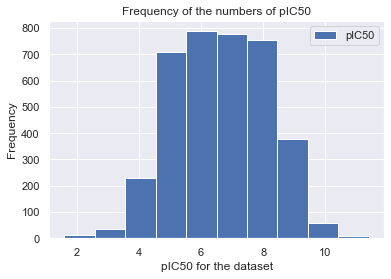

In [48]:
plt.hist(torch.flatten(pIC50_CNN_train, 0), label="pIC50", bins=10)
plt.title("Frequency of the numbers of pIC50")
plt.xlabel("pIC50 for the dataset")
plt.ylabel("Frequency")
plt.legend()
plt.show()

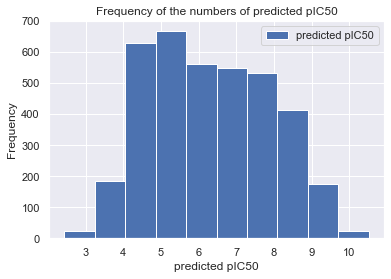

In [49]:
plt.hist(torch.flatten(predicted, 0), label="predicted pIC50", bins=10)
plt.title("Frequency of the numbers of predicted pIC50")
plt.xlabel("predicted pIC50")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Text(0, 0.5, 'predicted pIC50')

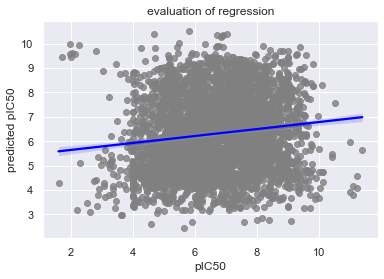

In [38]:
# to plot predicted against the pIC50
sns.set(color_codes=True)
ax = sns.regplot(x=np.array(torch.flatten(pIC50_CNN_train, 0)),
                 y=torch.flatten(predicted, 0),
                 scatter_kws={"color": "grey"}, line_kws={"color": "blue"})
plt.title('evaluation of regression')
# Set x-axis label
plt.xlabel('pIC50')
# Set y-axis label
plt.ylabel('predicted pIC50')

### Using the model to predict unknown pIC50 values

In [64]:
# This block is for the test dta set where the model is supposed to predict the PIC50
data_URL_test = ('https://raw.githubusercontent.com/volkamerlab/CADDSeminar_2020/'
                 'master/data/EGFR_test_set.csv?token=AFRFK52LRL2SEA3NEGGJAJS7APJZW')
df_test_data = pd.read_csv(data_URL_test)
df_test_data.head()

,id,canonical_smiles
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1
3,4,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
4,5,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


In [65]:
# Maximum length for the test data
print(df_test_data["canonical_smiles"].map(lambda x: len(x)).max())

87


In [66]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                60 non-null     int64 
 1   canonical_smiles  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [73]:
# one hot encoded array
one_hot_encode_test = [smiles_encoder(df_test_data.iloc[i, 1], 109) for i in range(60)]
len(one_hot_encode_test)

60

In [68]:
test_input = torch.Tensor(one_hot_encode_test)  # Create a tensor from our list

In [69]:
print("Array Type: {}".format(test_input.type))
print("Array Type: {}".format(test_input.shape))
print(test_input)

Array Type: <built-in method type of Tensor object at 0x7fa9e4fc7100>
Array Type: torch.Size([60, 109, 56])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [

In [70]:
test_input_CNN = test_input.resize_([60, 1, 109, 56])

In [71]:
print("Array Type: {}".format(test_input_CNN.type))
print("Array Type: {}".format(test_input_CNN.shape))
print(test_input_CNN)

Array Type: <built-in method type of Tensor object at 0x7fa9e4fc7100>
Array Type: torch.Size([60, 1, 109, 56])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 

In [74]:
with torch.no_grad():  # no need for gradients in the testing phase
    if torch.cuda.is_available():
        predicted_test = net(Variable(test_input_CNN.cuda())).cpu().data.numpy()
    else:
        predicted_test = net(Variable(test_input_CNN.view(-1, 1, 109, 56)))
        print(predicted_test)

tensor([[ 5.9075],
        [ 5.3720],
        [ 4.4811],
        [ 7.8384],
        [ 5.9661],
        [ 4.7353],
        [ 7.2186],
        [10.3184],
        [ 5.4584],
        [ 3.8109],
        [ 7.4477],
        [ 4.6223],
        [ 6.4927],
        [ 4.6342],
        [ 8.1117],
        [ 4.3474],
        [ 5.8398],
        [ 9.0473],
        [ 7.7657],
        [ 7.7000],
        [ 6.0072],
        [ 5.6928],
        [ 6.8391],
        [ 4.7841],
        [ 4.5879],
        [ 6.1490],
        [ 6.5264],
        [ 6.5756],
        [ 7.1650],
        [ 6.2001],
        [ 5.7652],
        [10.0507],
        [ 6.6837],
        [ 5.2249],
        [ 5.2887],
        [ 4.6036],
        [ 4.7745],
        [ 6.3922],
        [ 4.4955],
        [ 6.1031],
        [ 6.4478],
        [ 5.5290],
        [ 3.7547],
        [ 3.6842],
        [ 6.8985],
        [ 6.2109],
        [ 7.2375],
        [ 5.7380],
        [ 5.2238],
        [ 9.3390],
        [ 8.2792],
        [ 7.2988],
        [ 9.

### Comparison with T04 project
In this part we use different methods to compare the predicted results on the test set between CNN model(T05) and T04 model

In [77]:
# T04 data acquisition (locally)
df_T04_data = pd.read_csv(f"{data_dir}/T04_predicted_pic50_df.csv")

In [130]:
# T04 data acquisition (internet)
URL_T04_predictions = ('https://raw.githubusercontent.com/volkamerlab/CADDSeminar_2020/'
                       '7fe00717661e5ca5eb6596ec81dcb7adf139992b/T0'
                       '4_predicted_pic50_df.csv?token=AFRFK52WHTFV5TLHOKDZRBS7AXGF4')
df_T04_data = pd.read_csv(URL_T04_predictions)

In [128]:
df_T04_data.head()

,Unnamed: 0,id,canonical_smiles,pedicded_pic50
0,0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,5.779419
1,1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,5.483405
2,2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,5.343009
3,3,4,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...,7.229651
4,4,5,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...,6.080912


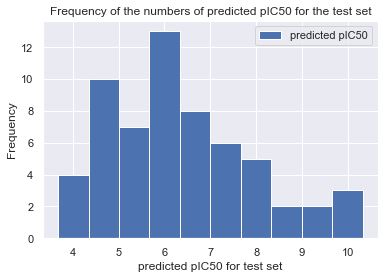

In [75]:
# Predictions based on the CNN
plt.hist(torch.flatten(predicted_test, 0), label="predicted pIC50", bins=10)
plt.title("Frequency of the numbers of predicted pIC50 for the test set")
plt.xlabel("predicted pIC50 for test set")
plt.ylabel("Frequency")
plt.legend()
plt.show()

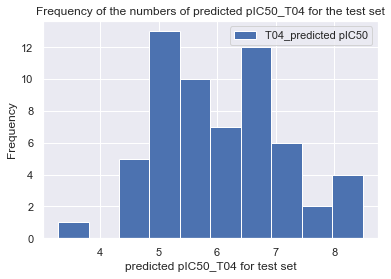

In [79]:
# Data from T04 project
plt.hist(df_T04_data["pedicded_pic50"], label="T04_predicted pIC50", bins=10)
plt.title("Frequency of the numbers of predicted pIC50_T04 for the test set")
plt.xlabel("predicted pIC50_T04 for test set")
plt.ylabel("Frequency")
plt.legend()
plt.show()

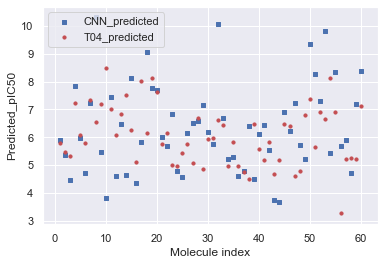

In [96]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(df_T04_data["id"], predicted_test,
            s=10, c='b', marker="s", label='CNN_predicted')
ax1.scatter(df_T04_data["id"], df_T04_data["pedicded_pic50"],
            s=10, c='r', marker="o", label='T04_predicted')
plt.legend(loc='upper left')
plt.xlabel("Molecule index")
plt.ylabel("Predicted_pIC50")
plt.show()

In [114]:
difference_CNN_T04 = torch.flatten(predicted_test, 0)-df_T04_data["pedicded_pic50"]

In [115]:
difference_CNN_T04

0     0.128092
1    -0.111377
2    -0.861869
3     0.608734
4    -0.114815
5    -1.077383
6    -0.134274
7     3.759865
8    -1.726664
9    -4.670894
10    0.424796
11   -1.445394
12   -0.343385
13   -2.880597
14    1.833106
15   -0.759543
16   -2.166300
17    2.893125
18   -0.354584
19    0.062026
20    0.255001
21   -0.471871
22    1.844836
23   -0.183932
24   -0.859977
25    0.382986
26    1.451019
27   -0.110085
28    2.305443
29    0.278570
30   -0.211326
31    3.421933
32    0.258547
33    0.265707
34   -0.543178
35   -0.369369
36    0.025143
37    1.885786
38   -1.988281
39    0.523286
40    1.250069
41   -0.297799
42   -0.919178
43   -1.487300
44    0.412388
45   -0.200439
46    2.640234
47    0.945942
48   -1.593749
49    1.954748
50    2.625065
51    0.401865
52    3.184809
53   -2.710727
54    1.420062
55    2.410956
56    0.698168
57   -0.558729
58    1.982837
59    1.271647
Name: pedicded_pic50, dtype: float64

In [116]:
difference_CNN_T04_array = np.array(difference_CNN_T04)

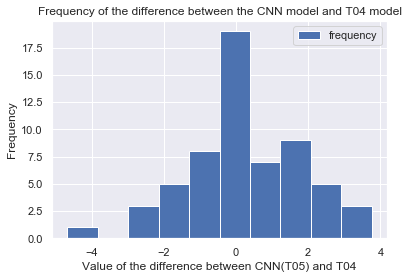

In [123]:
plt.hist(difference_CNN_T04_array, label="frequency")
plt.title("Frequency of the difference between the CNN model and T04 model")
plt.xlabel("Value of the difference between CNN(T05) and T04")
plt.ylabel("Frequency")
plt.legend()
plt.show()

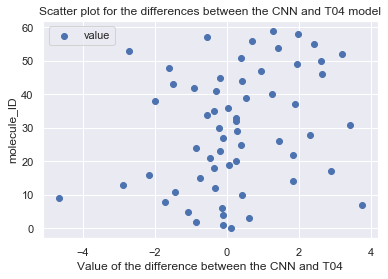

In [124]:
plt.scatter(difference_CNN_T04_array, range(60), label="value")
plt.title("Scatter plot for the differences between the CNN and T04 model")
plt.xlabel("Value of the difference between the CNN and T04")
plt.ylabel("molecule_ID")
plt.legend()
plt.show()